# Time-averaged fluxes
## Question: How does sub-time variability impact time-averaged fluxes? 

### Follow on to Mahrt 1987 "Grid-Averaged Surface Fluxes"

- Use the turbpy python package to answer this question in a synthetic study
- Prescribe variability in Tair (assume that wind, water vapor, and surface temperature are fairly constant at small time scales) and determine how time variability in Tair impacts time-averaged conductance, Richardson number, and simulated turbulent fluxes

In [15]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import solargeo
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

### Prescribe all boundary conditions except air temperature


In [16]:
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')
sfcTemp = 265.
airTemp_mean = 273
windspd = 1.0
mHeight = 3.
z0Ground = .005
snowDepth = 1.
scalarGroundSnowFraction  = 1.
(airVaporPress,_) = turbpy.satVapPress(airTemp_mean)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp-273.)
airPressure = 101000.
colr = kgraph.SRON(4)

### Vary air temperature in four scenarios
Skewed distributions area a little hard to make. Check out:
    - https://en.wikipedia.org/wiki/Generalized_normal_distribution
    - http://stackoverflow.com/questions/10814363/apply-kurtosis-to-a-distribution-in-python
    - http://stackoverflow.com/questions/19604389/how-to-generate-a-distribution-with-a-given-mean-variance-skew-and-kurtosis-in

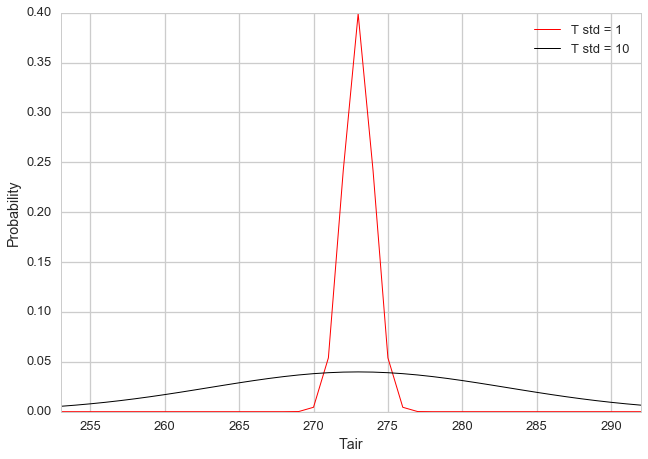

In [17]:
numSamples = 1000 
smallVar = 1
largeVar = 10
airTemp_smallVar = np.random.normal(airTemp_mean, smallVar, numSamples)
airTemp_largeVar = np.random.normal(airTemp_mean, largeVar, numSamples)

RiBulk_smallVar,_,_ = turbpy.bulkRichardson(airTemp_smallVar,sfcTemp,windspd,mHeight)
RiBulk_largeVar,_,_ = turbpy.bulkRichardson(airTemp_largeVar,sfcTemp,windspd,mHeight)

import matplotlib.mlab as mlab
fig, ax = plt.subplots(1,1)
bins = np.arange(airTemp_mean-20,airTemp_mean+20)
y = mlab.normpdf( bins, airTemp_mean, smallVar)
ax.plot(bins, y, 'r', linewidth=1, label='T std = 1')
y = mlab.normpdf( bins, airTemp_mean, largeVar)
ax.plot(bins, y, 'k', linewidth=1, label='T std = 10')
ax.legend()
ax.set_xlim(min(bins),max(bins))
ax.set_xlabel('Tair')
ax.set_ylabel('Probability')

### How does Ri behave with the synthetic dataset?

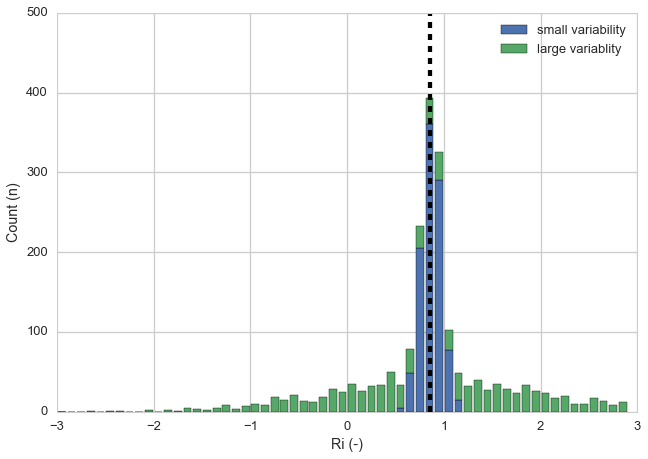

In [18]:
fig, ax = plt.subplots(1,1)
ax.hist([RiBulk_smallVar, RiBulk_largeVar], bins=np.arange(-3,3,.1),
        stacked=True, label=['small variability','large variablity']);
ax.plot([np.mean(RiBulk_smallVar),np.mean(RiBulk_smallVar)],[0,500],'k--')
ax.plot([np.mean(RiBulk_largeVar),np.mean(RiBulk_largeVar)],[0,500],'k--')
ax.legend()
ax.set_xlabel('Ri (-)')
ax.set_ylabel('Count (n)')

## Stability and related parameters

In [19]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
stability_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }
conductanceSensible_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }
conductanceLatent_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }

for stab in ixStability:
    for n,tair in enumerate(airTemp_smallVar):
        (_,stabOutput,_,
         conductanceSensible_smallVar[stab][n],
         conductanceLatent_smallVar[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               airVaporPress, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stability_smallVar[stab][n] = stabOutput['stabilityCorrection']
            
# -------------------------------------------------------------------------------------------------------
# large temperature variability
# -------------------------------------------------------------------------------------------------------
stability_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }
conductanceSensible_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }
conductanceLatent_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }

for stab in ixStability:
    for n,tair in enumerate(airTemp_largeVar):
        (_,stabOutput,_,
         conductanceSensible_largeVar[stab][n],
         conductanceLatent_largeVar[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               airVaporPress, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stability_largeVar[stab][n] = stabOutput['stabilityCorrection']

## Fluxes

In [20]:
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_largeVar = xray.Dataset()
latent_largeVar = xray.Dataset()

for stab in ixStability:
    senHeatGround = np.ones_like(airTemp_largeVar)*np.nan
    latHeatGround = np.ones_like(airTemp_largeVar)*np.nan
    
    for n,tair in enumerate(airTemp_largeVar):
        # Offline turbulence
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )

    sensible_largeVar[stab] = (('n'),senHeatGround)
    latent_largeVar[stab] = (('n'),latHeatGround)
    
# -------------------------------------------------------------------------------------------------------
# small temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_smallVar = xray.Dataset()
latent_smallVar = xray.Dataset()

for stab in ixStability:
    senHeatGround = np.ones_like(airTemp_smallVar)*np.nan       # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.ones_like(airTemp_smallVar)*np.nan       # latent heat flux from ground surface (W m-2)
    
    for n,tair in enumerate(airTemp_smallVar):
        # Offline turbulence
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )

    sensible_smallVar[stab] = (('n'),senHeatGround)
    latent_smallVar[stab] = (('n'),latHeatGround)

# Figures
## Stability Corrections

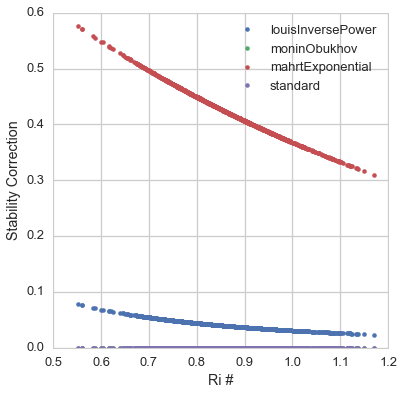

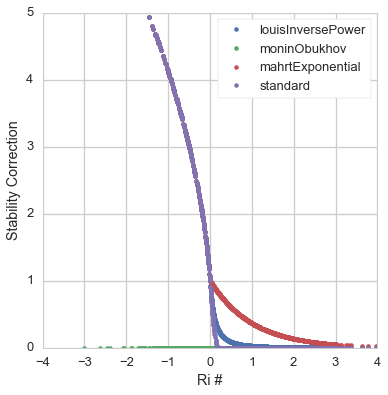

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stability_smallVar:
    ax.plot(RiBulk_smallVar,stability_smallVar[stab],'.',label=stab)
ax.legend(loc='best')
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stability_largeVar:
    ax.plot(RiBulk_largeVar,stability_largeVar[stab],'.',label=stab)
ax.legend(loc='best',frameon=True)
ax.set_ylim(0,5)
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

### Conductance

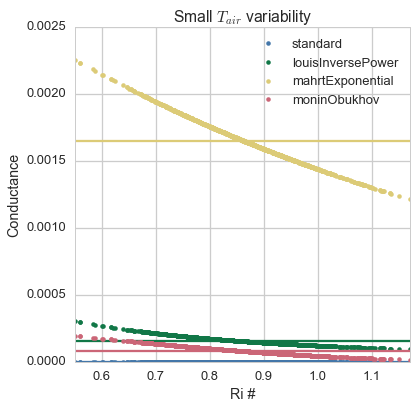

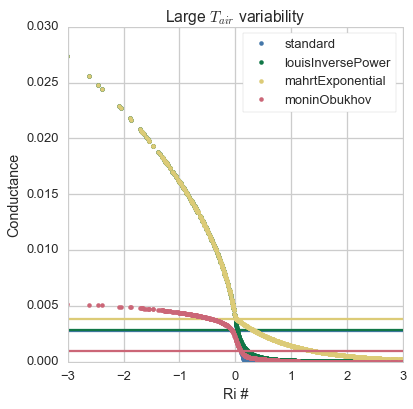

In [22]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_smallVar, conductanceSensible_smallVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
        [np.mean(conductanceSensible_smallVar[stab]), np.mean(conductanceSensible_smallVar[stab])],
        color=colr[n])
ax.set_xlim(min(RiBulk_smallVar),max(RiBulk_smallVar))
ax.legend(loc='best')
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Small $T_{air}$ variability')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_largeVar, conductanceSensible_largeVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
            [np.mean(conductanceSensible_largeVar[stab]), np.mean(conductanceSensible_largeVar[stab])],
            color=colr[n])
ax.set_xlim(-3,3)
ax.legend(loc='best',frameon=True)
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Large $T_{air}$ variability')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_smallVar, conductanceSensible_smallVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
        [np.mean(conductanceSensible_smallVar[stab]), np.mean(conductanceSensible_smallVar[stab])],
        color=colr[n])
ax.set_xlim(min(RiBulk_smallVar),max(RiBulk_smallVar))
ax.legend(loc='best')
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Small $T_{air}$ variability')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_largeVar, conductanceSensible_largeVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
            [np.mean(conductanceSensible_largeVar[stab]), np.mean(conductanceSensible_largeVar[stab])],
            color=colr[n])
ax.set_xlim(-3,3)
ax.legend(loc='best',frameon=True)
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Large $T_{air}$ variability')

## Fluxes
### PDF/Histogram distributions

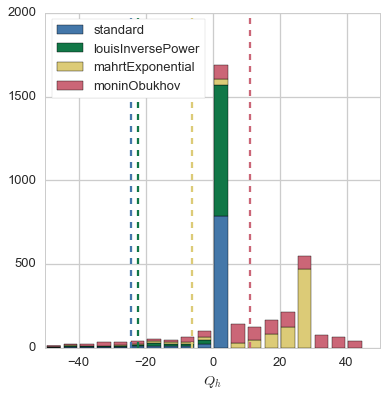

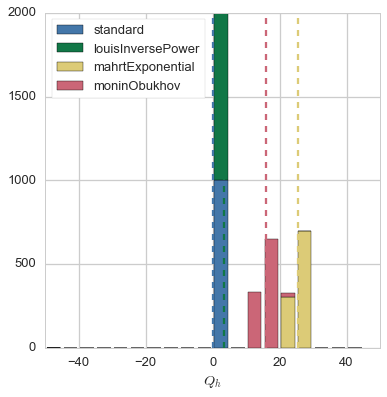

In [23]:
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([sensible_largeVar.standard, sensible_largeVar.louisInversePower,\
        sensible_largeVar.mahrtExponential, sensible_largeVar.moninObukhov], \
        bins=np.arange(-50,50,5), stacked=True, color = colr, label = ixStability);
for n,stab in enumerate(ixStability):
    ax.plot([sensible_largeVar[stab].mean(dim='n'), sensible_largeVar[stab].mean(dim='n')], [0, 2000],\
            '--', color=colr[n])
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-50,50)
ax.set_xlabel('$Q_h$')

# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([sensible_smallVar.standard, sensible_smallVar.louisInversePower,
        sensible_smallVar.mahrtExponential, sensible_smallVar.moninObukhov],
        bins=np.arange(-50,50,5), stacked=True, color=colr, label=ixStability);
for n,stab in enumerate(ixStability):
    ax.plot([sensible_smallVar[stab].mean(dim='n'), sensible_smallVar[stab].mean(dim='n')], [0, 2000],\
            '--', color=colr[n])
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-50,50)
ax.set_xlabel('$Q_h$')

### CDFs

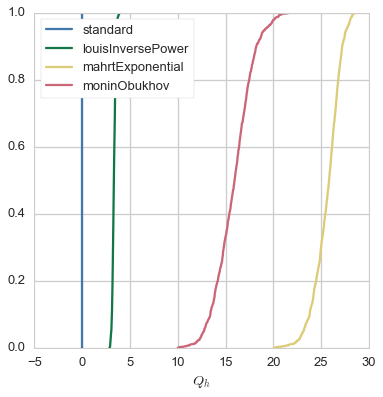

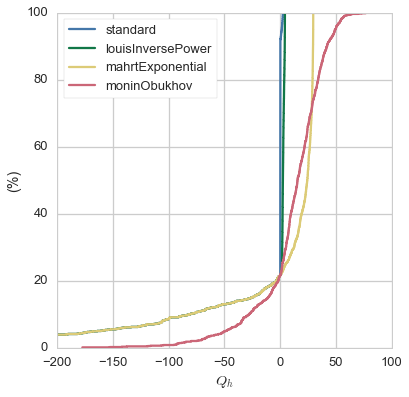

In [34]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(sensible_smallVar[stab])
    ax.plot(sorted_data, np.arange(sorted_data.size) / float(numSamples), color=colr[n], label=stab)
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-5,30)
ax.set_xlabel('$Q_h$')

# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(sensible_largeVar[stab])
    ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100, color=colr[n], label=stab)
ax.legend(loc='upper left',frameon=True)
ax.set_ylabel('(%)')
ax.set_xlim(-200,100)
ax.set_xlabel('$Q_h$')

### What drives the weird behavior of the CDF, $\Delta T$ or $C_h$?

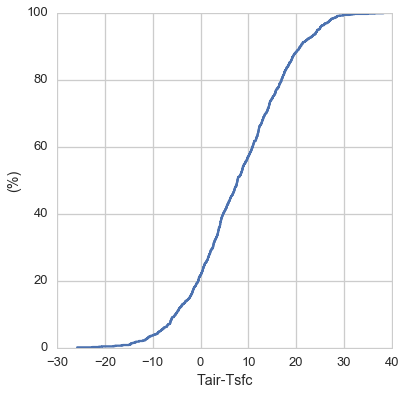

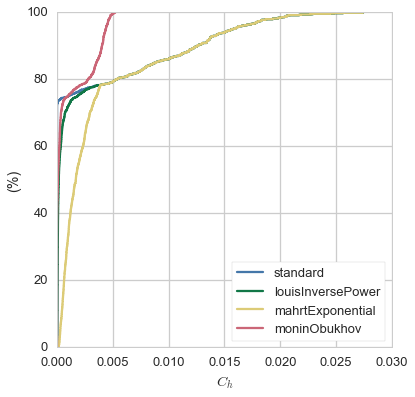

In [37]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
# Cumulative distributions:
sorted_data = np.sort(airTemp_largeVar - sfcTemp)
ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100)
ax.set_ylabel('(%)')
ax.set_xlabel('Tair-Tsfc')

fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(conductanceSensible_largeVar[stab])
    ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100, color=colr[n], label=stab)
ax.legend(loc='lower right',frameon=True)
ax.set_ylabel('(%)')
ax.set_xlabel('$C_h$')

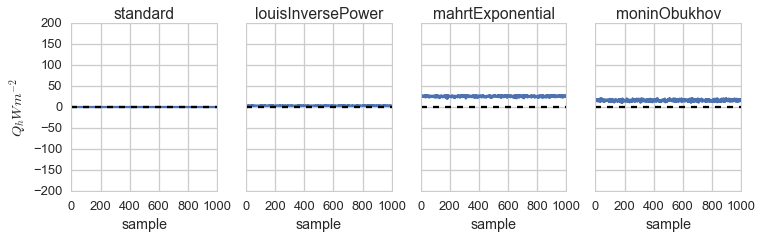

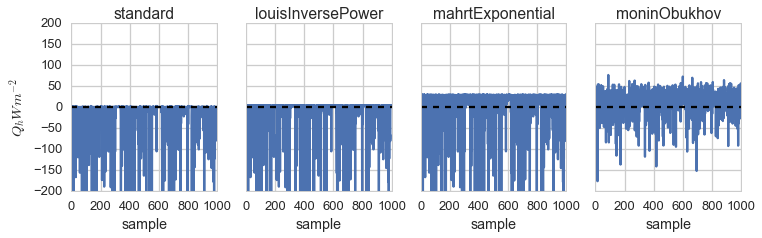

In [25]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
axes = axes.flatten()
for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(sensible_smallVar[stab])
    ax.plot([0,sensible_smallVar.n.max()],[0,0],'k--')
    ax.set_xlabel('sample')
    if n == 0:
        ax.set_ylabel('$Q_h Wm^{-2}$')
    ax.set_title(stab)
    ax.set_ylim(-200,200)
    
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
axes = axes.flatten()
for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(sensible_largeVar[stab])
    ax.plot([0,sensible_largeVar.n.max()],[0,0],'k--')
    ax.set_xlabel('sample')
    if n == 0:
        ax.set_ylabel('$Q_h Wm^{-2}$')
    ax.set_title(stab)
    ax.set_ylim(-200,200)

## $Q_h$ as a function of std($T_{air}$)

In [44]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_var = np.arange(1,11)
sensMean = np.zeros((10,4))

for istab,stab in enumerate(ixStability):
    for istd,tair_std in enumerate(airTemp_var):
        airTemp_rand = np.random.normal(airTemp_mean, tair_std, numSamples)
        senHeatGround = np.ones(numSamples)*np.nan

        for n,tair in enumerate(airTemp_rand):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[istd,istab] = np.mean(senHeatGround)


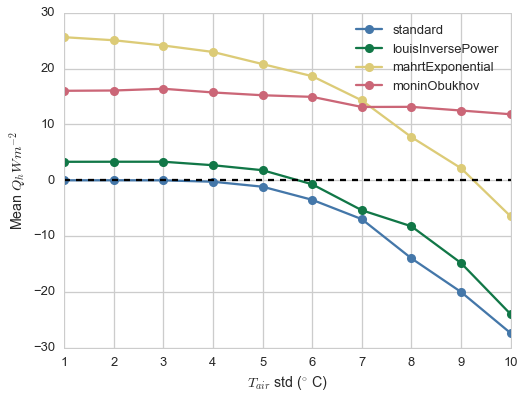

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(airTemp_var,sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([1,10],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('$T_{air}$ std ($^{\circ}$ C)')
ax.legend()

## $Q_h$ as a function of mean wind speed

In [50]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
sensMean = np.zeros((10,4))
windspd_mean = np.arange(.5,5.5,.5)

for istab,stab in enumerate(ixStability):
    for nWindMean,WindMean in enumerate(windspd_mean):
        senHeatGround = np.ones(numSamples)*np.nan
        
        for n,tair in enumerate(airTemp_largeVar):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, WindMean, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[nWindMean,istab] = np.nanmean(senHeatGround)


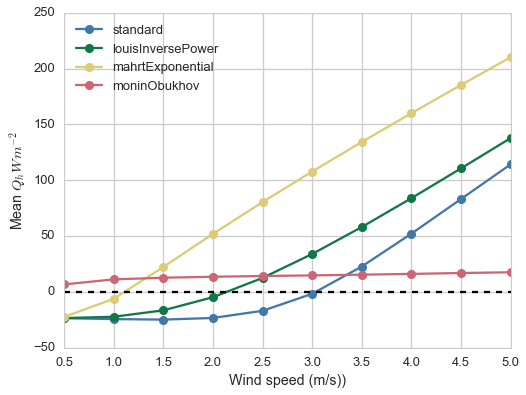

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(windspd_mean,sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([min(windspd_mean),max(windspd_mean)],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('Wind speed (m/s))')
ax.legend(loc='upper left')

In [63]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_mean = np.arange(253,293)
airTemp_var = 10
sensMean = np.zeros((airTemp_mean.size,4))

for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        airTemp_rand = np.random.normal(tair_mean, airTemp_var, numSamples)
        senHeatGround = np.ones(numSamples)*np.nan

        for n,tair in enumerate(airTemp_rand):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[imean, istab] = np.mean(senHeatGround)


(-12.0, 27.0)

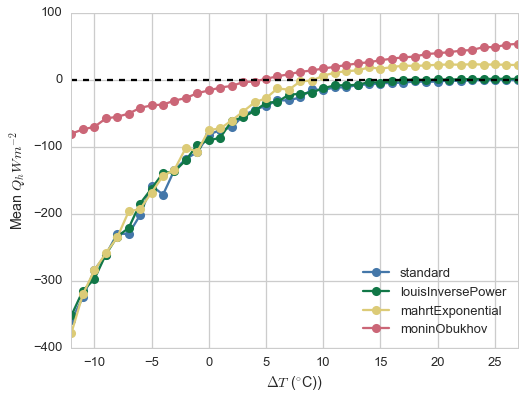

In [64]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(airTemp_mean -sfcTemp, sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('$\Delta T$ ($^{\circ}$C))')
ax.legend(loc='lower right')
ax.set_xlim(min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp)

In [65]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_mean = np.arange(253,293)
airTemp_var = np.arange(1,11)
sensMean = np.zeros((airTemp_mean.size,airTemp_var.size,4))

for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        for istd, tair_std in enumerate(airTemp_var):
            airTemp_rand = np.random.normal(tair_mean, tair_std, numSamples)
            senHeatGround = np.ones(numSamples)*np.nan

            for n,tair in enumerate(airTemp_rand):
                # Offline turbulence
                (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                    tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                    groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                    )
            sensMean[imean, istd, istab] = np.mean(senHeatGround)


In [ ]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
for istab,stab in enumerate(ixStability):
    ax.(airTemp_mean -sfcTemp, sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('$\Delta T$ ($^{\circ}$C))')
ax.legend(loc='lower right')
ax.set_xlim(min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp)